<a href="https://colab.research.google.com/github/Valiev-Koyiljon/Pytorch/blob/main/notebook_source__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with Logistic Regression (Minimal)

In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [6]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [7]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

In [8]:
jovian.reset()
jovian.log_hyperparams(batch_size=batch_size, learning_rate=learning_rate)

[jovian] Hyperparams logged.


## Dataset & Data loaders

In [10]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: 3


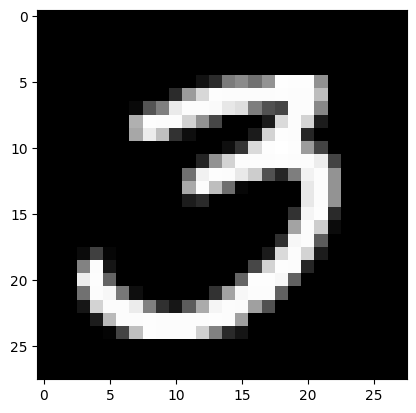

In [11]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

## Model

In [16]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

model = MnistModel()

## Training

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [19]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
evaluate(model, val_loader)

{'val_loss': 2.3259167671203613, 'val_acc': 0.09072265774011612}

In [38]:
history = fit(5, 0.0088, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6811, val_acc: 0.8548
Epoch [1], val_loss: 0.5904, val_acc: 0.8677
Epoch [2], val_loss: 0.5375, val_acc: 0.8735
Epoch [3], val_loss: 0.5029, val_acc: 0.8771
Epoch [4], val_loss: 0.4775, val_acc: 0.8815


In [39]:
history1 = fit(5, 0.0088, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4586, val_acc: 0.8840
Epoch [1], val_loss: 0.4430, val_acc: 0.8861
Epoch [2], val_loss: 0.4306, val_acc: 0.8883
Epoch [3], val_loss: 0.4204, val_acc: 0.8898
Epoch [4], val_loss: 0.4114, val_acc: 0.8896


In [40]:
historyZ = history+history1

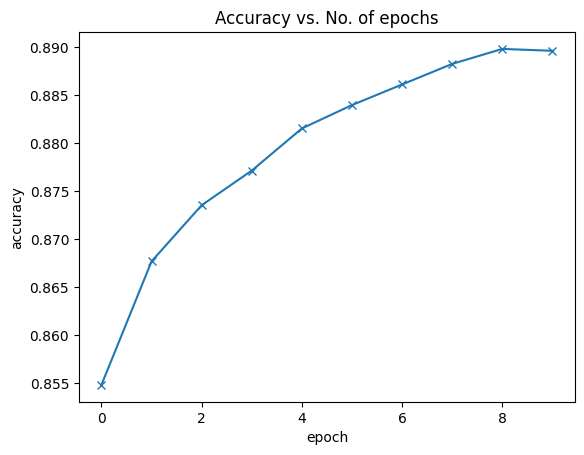

In [41]:
accuracies = [r['val_acc'] for r in historyZ]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [42]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.39293545484542847, 'val_acc': 0.8965820074081421}

In [43]:


jovian.log_metrics(test_acc=result['val_acc'], test_loss=result['val_loss'])

[jovian] Metrics logged.


## Prediction

In [47]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


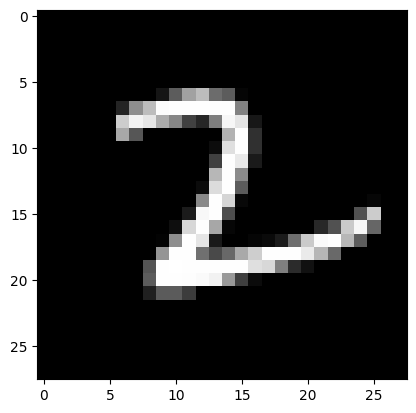

In [48]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

label:9,  predicted: 9


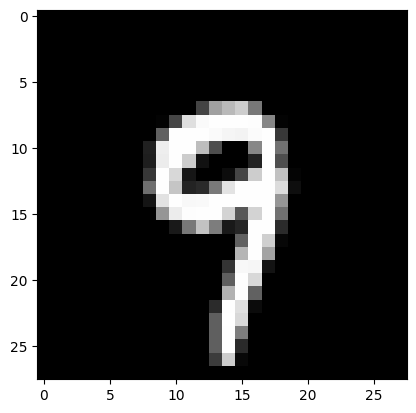

In [53]:
img, label = test_ds[4843]
plt.imshow(img[0], cmap="gray")
print(f"label:{label},  predicted: {predict_image(img, model)}")

## Save and upload

In [54]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [55]:
jovian.commit(project='mnist-logistic-minimal', environment=None, outputs=['mnist-logistic.pth'])
jovian.commit(project='mnist-logistic-minimal', environment=None, outputs=['mnist-logistic.pth']) # Kaggle commit fails sometimes, so try again..

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.
